In [2]:
# importing modules

import numpy as np
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import (InputLayer, Conv2D, MaxPooling2D, MaxPool2D, Flatten, 
                          Dense, BatchNormalization, Dropout, ELU, UpSampling2D)
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Nadam
from keras.layers import Input, Multiply, UpSampling2D
from keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

2024-05-29 09:52:10.825698: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 09:52:10.825808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 09:52:10.943066: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split

def is_image_dark(image, threshold=30):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mean_intensity = np.mean(gray_image)
    return mean_intensity < threshold

def image_to_hash(image):
    resized = cv2.resize(image, (8, 8))
    gray_image = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    return tuple(gray_image.flatten())

def is_grayscale(image):
    if len(image.shape) == 2:  # Image is already grayscale
        return True
    elif len(image.shape) == 3 and image.shape[2] == 1:  # Single-channel image
        return True
    elif len(image.shape) == 3 and image.shape[2] == 3:  # Check if R, G, B channels are equal
        return np.all(image[:,:,0] == image[:,:,1]) and np.all(image[:,:,1] == image[:,:,2])
    return False

def apply_color_jitter(image):
    # Randomly adjust brightness, contrast, saturation, and hue
    brightness = np.random.uniform(0.8, 1.2)
    contrast = np.random.uniform(0.8, 1.2)
    saturation = np.random.uniform(0.8, 1.2)

    # Convert image to float32 for calculations
    image = image.astype(np.float32) / 255.0

    # Adjust brightness
    image *= brightness

    # Adjust contrast
    image = (image - 0.5) * contrast + 0.5
    image = np.clip(image, 0, 1)

    # Adjust saturation
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = np.stack([gray_image] * 3, axis=-1)  # Convert grayscale to 3 channels
    image = image * saturation + gray_image * (1 - saturation)

    # Convert back to uint8
    image = (image * 255).astype(np.uint8)
    
    return image

data_dir = "/kaggle/input/mushroom-classification/archive/Mushrooms"

# Create a mapping between category names and integer labels
category_map = {category: idx for idx, category in enumerate(sorted(os.listdir(data_dir)))}

# Load the dataset
images_list = []
labels_list = []
max_images_per_category = 300
seen_hashes = set()

for label_dir in os.listdir(data_dir):
    label_path = os.path.join(data_dir, label_dir)
    if os.path.isdir(label_path):
        label = category_map[label_dir]  # Get the integer label from the mapping
        category_images = 0
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            try:
                image = cv2.imread(image_path)
                if image is not None:
                    # Check if the image is grayscale
                    if is_grayscale(image):
                        continue

                    # Check if the image is dark
                    if is_image_dark(image):
                        continue

                    # Check for duplicates
                    image_hash = image_to_hash(image)
                    if image_hash in seen_hashes:
                        continue
                    seen_hashes.add(image_hash)

                    # Apply color jitter
                    jittered_image = apply_color_jitter(image)

                    # Resize the image to 400x400
                    resized_image = cv2.resize(jittered_image, (224, 224))

                    images_list.append(resized_image)
                    labels_list.append(label)
                    category_images += 1

                    # Stop loading images for this category once we reach the limit
                    if category_images >= max_images_per_category:
                        break
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
                continue

# Convert to numpy arrays
images_array = np.array(images_list)
labels_array = np.array(labels_list)

# Normalize the images
images_array = images_array / 255.0

# One-hot encode the labels
num_categories = len(category_map)
predictor_labels = np.eye(num_categories)[labels_array]

# Split the data
x_train, x_temp, y_train, y_temp = train_test_split(images_array, predictor_labels, test_size=0.3, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Print shapes
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)


Premature end of JPEG file


x_train: (1890, 224, 224, 3)
y_train: (1890, 9)
x_test: (405, 224, 224, 3)
y_test: (405, 9)
x_val: (405, 224, 224, 3)
y_val: (405, 9)


### VGG16

In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the VGG16 model and create the feature extractor
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('block5_pool').output)

# Freeze the convolutional base layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Add custom dense layers on top
x = feature_extractor.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(9, activation='softmax')(x)

# Create the final model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,16

 Total params: 21,171,529 (80.76 MB)

 Trainable params: 6,456,841 (24.63 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [5]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
 1/60 ━━━━━━━━━━━━━━━━━━━━ 33:14 34s/step - accuracy: 0.0625 - loss: 2.8669

I0000 00:00:1716976453.598292      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716976453.618716      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.1220 - loss: 3.5424

W0000 00:00:1716976468.191830      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716976469.899215      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.14568, saving model to att_model.keras


W0000 00:00:1716976491.907336      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 73s 656ms/step - accuracy: 0.1222 - loss: 3.5296 - val_accuracy: 0.1457 - val_loss: 2.1531 - learning_rate: 0.0010
Epoch 2/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.1598 - loss: 2.1473
Epoch 2: val_accuracy improved from 0.14568 to 0.20000, saving model to att_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.1598 - loss: 2.1475 - val_accuracy: 0.2000 - val_loss: 2.1297 - learning_rate: 0.0010
Epoch 3/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.1666 - loss: 2.1507
Epoch 3: val_accuracy did not improve from 0.20000
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.1664 - loss: 2.1504 - val_accuracy: 0.1802 - val_loss: 2.0652 - learning_rate: 0.0010
Epoch 4/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.1613 - loss: 2.1420
Epoch 4: val_accuracy did not improve from 0.20000
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.1615 - loss: 2.1414 - val_accuracy: 0.1778 - val_loss: 2.0750 - learning_

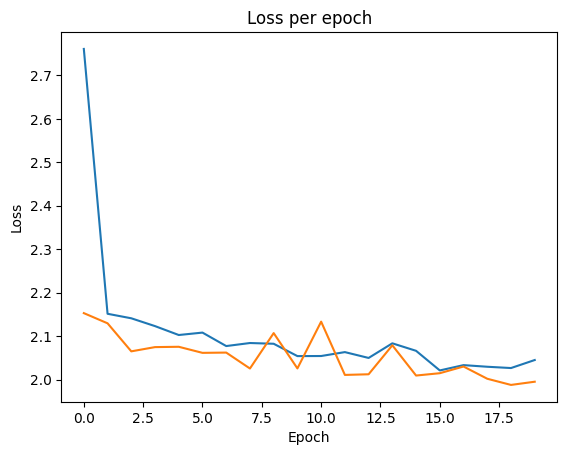

In [6]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

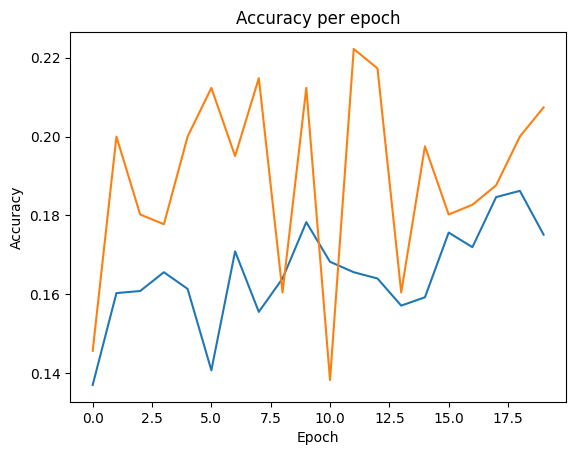

In [7]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### RESNET50

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the ResNet50 model and create the feature extractor
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=resnet50_model.input, outputs=resnet50_model.get_layer('conv5_block3_out').output)

# Freeze the convolutional base layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Add custom dense layers on top
x = feature_extractor.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(9, activation='softmax')(x)

# Create the final model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('att_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

# Print the model summary
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 49,312,137 (188.11 MB)

 Trainable params: 25,724,425 (98.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.1060 - loss: 5.6215
Epoch 1: val_accuracy improved from -inf to 0.09630, saving model to att_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 47s 466ms/step - accuracy: 0.1060 - loss: 5.5865 - val_accuracy: 0.0963 - val_loss: 2.1974 - learning_rate: 0.0010
Epoch 2/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.1140 - loss: 2.2070
Epoch 2: val_accuracy did not improve from 0.09630
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.1141 - loss: 2.2069 - val_accuracy: 0.0963 - val_loss: 2.1981 - learning_rate: 0.0010
Epoch 3/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.1368 - loss: 2.1966
Epoch 3: val_accuracy did not improve from 0.09630
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.1363 - loss: 2.1966 - val_accuracy: 0.0963 - val_loss: 2.1988 - learning_rate: 0.0010
Epoch 4/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.1242 - loss: 2.2465
Epoch 4: val_accuracy did not improve from 0.096

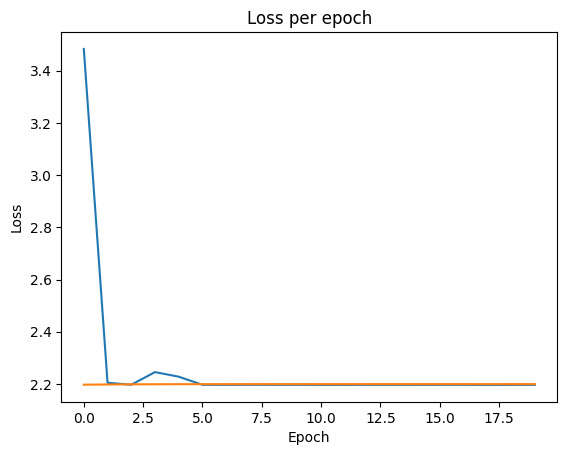

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

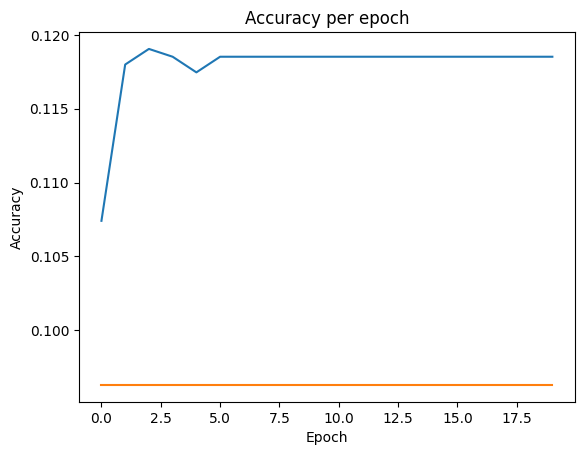

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### Xception

In [14]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the Xception model and create the feature extractor
xception_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=xception_model.input, outputs=xception_model.get_layer('block14_sepconv2_act').output)

# Freeze the convolutional base layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Add custom dense layers on top
x = feature_extractor.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(9, activation='softmax')(x)

# Create the final model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('att_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

# Print the model summary
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_3[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add_12[0][0]    

 Total params: 46,585,905 (177.71 MB)

 Trainable params: 25,724,425 (98.13 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32, callbacks=[reduce_lr, model_checkpoint])

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.1480 - loss: 11.8773
Epoch 1: val_accuracy improved from -inf to 0.14568, saving model to att_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 53s 531ms/step - accuracy: 0.1479 - loss: 11.7895 - val_accuracy: 0.1457 - val_loss: 2.1620 - learning_rate: 0.0010
Epoch 2/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.1374 - loss: 2.2499
Epoch 2: val_accuracy did not improve from 0.14568
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.1375 - loss: 2.2492 - val_accuracy: 0.1259 - val_loss: 2.1682 - learning_rate: 0.0010
Epoch 3/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.1160 - loss: 2.2016
Epoch 3: val_accuracy did not improve from 0.14568
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.1165 - loss: 2.2016 - val_accuracy: 0.1407 - val_loss: 2.1483 - learning_rate: 0.0010
Epoch 4/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.1539 - loss: 2.2231
Epoch 4: val_accuracy did not improve from 

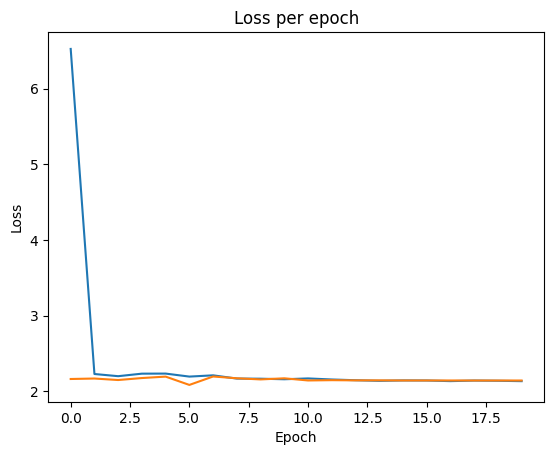

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

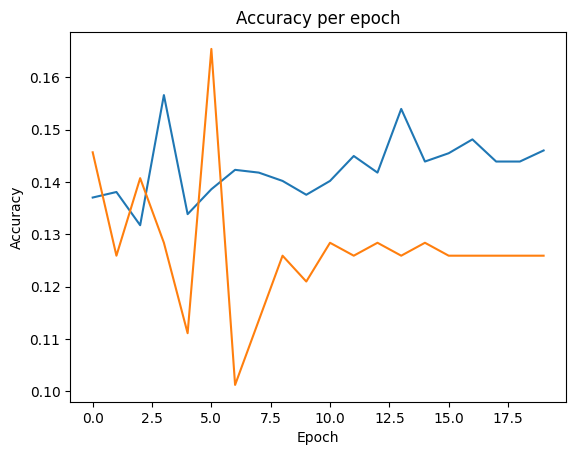

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### DenseNet121

In [20]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the DenseNet121 model and create the feature extractor
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=densenet_model.input, outputs=densenet_model.get_layer('relu').output)

# Freeze the convolutional base layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Add custom dense layers on top
x = feature_extractor.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(9, activation='softmax')(x)

# Create the final model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('att_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

# Print the model summary
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 19,916,873 (75.98 MB)

 Trainable params: 12,879,369 (49.13 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32, callbacks=[reduce_lr, model_checkpoint])

Epoch 1/20
 2/60 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.1328 - loss: 10.1783 

W0000 00:00:1716977405.982438      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.1370 - loss: 10.1512

W0000 00:00:1716977426.757400      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716977437.640871      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.13580, saving model to att_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 88s 859ms/step - accuracy: 0.1370 - loss: 10.0747 - val_accuracy: 0.1358 - val_loss: 2.1651 - learning_rate: 0.0010
Epoch 2/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.1388 - loss: 2.2571
Epoch 2: val_accuracy did not improve from 0.13580
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.1386 - loss: 2.2567 - val_accuracy: 0.1235 - val_loss: 2.1872 - learning_rate: 0.0010
Epoch 3/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.1355 - loss: 2.2280
Epoch 3: val_accuracy improved from 0.13580 to 0.16049, saving model to att_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.1354 - loss: 2.2276 - val_accuracy: 0.1605 - val_loss: 2.1167 - learning_rate: 0.0010
Epoch 4/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.1477 - loss: 2.1819
Epoch 4: val_accuracy improved from 0.16049 to 0.16543, saving model to att_model.keras
60/60 ━━

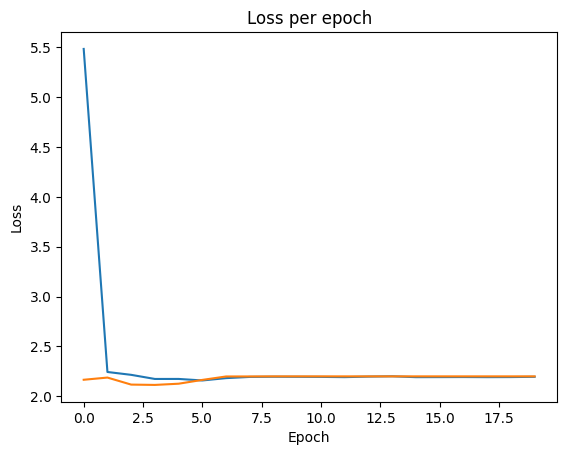

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

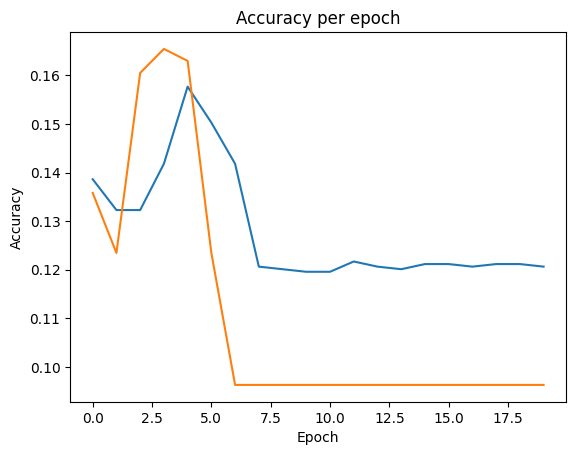

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### Inception-ResNet-V2

In [24]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the InceptionResNetV2 model and create the feature extractor
inception_resnet_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=inception_resnet_model.input, outputs=inception_resnet_model.get_layer('conv_7b_ac').output)

# Freeze the convolutional base layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Add custom dense layers on top
x = feature_extractor.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(9, activation='softmax')(x)

# Create the final model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('att_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

# Print the model summary
model.summary()

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 111, 111,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 64,201,449 (244.91 MB)

 Trainable params: 9,864,713 (37.63 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32, callbacks=[reduce_lr, model_checkpoint])

Epoch 1/20
 1/60 ━━━━━━━━━━━━━━━━━━━━ 40:57 42s/step - accuracy: 0.0625 - loss: 4.9704

W0000 00:00:1716977627.527992      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.1212 - loss: 12.5788

W0000 00:00:1716977652.259075      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716977664.925310      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.11111, saving model to att_model.keras


W0000 00:00:1716977681.437478      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 98s 954ms/step - accuracy: 0.1213 - loss: 12.4844 - val_accuracy: 0.1111 - val_loss: 2.1885 - learning_rate: 0.0010
Epoch 2/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.1108 - loss: 2.2314
Epoch 2: val_accuracy improved from 0.11111 to 0.13827, saving model to att_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 217ms/step - accuracy: 0.1113 - loss: 2.2310 - val_accuracy: 0.1383 - val_loss: 2.1838 - learning_rate: 0.0010
Epoch 3/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.1410 - loss: 2.2074
Epoch 3: val_accuracy did not improve from 0.13827
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.1404 - loss: 2.2073 - val_accuracy: 0.0963 - val_loss: 2.1983 - learning_rate: 0.0010
Epoch 4/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.1173 - loss: 2.2065
Epoch 4: val_accuracy did not improve from 0.13827
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.1174 - loss: 2.2066 - val_accuracy: 0.0963 - val_loss: 2.1980 - learn

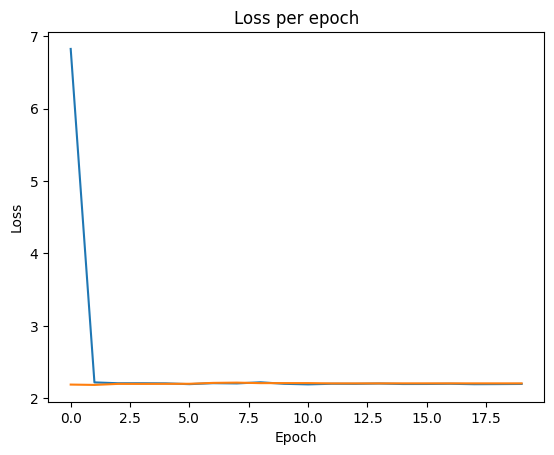

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

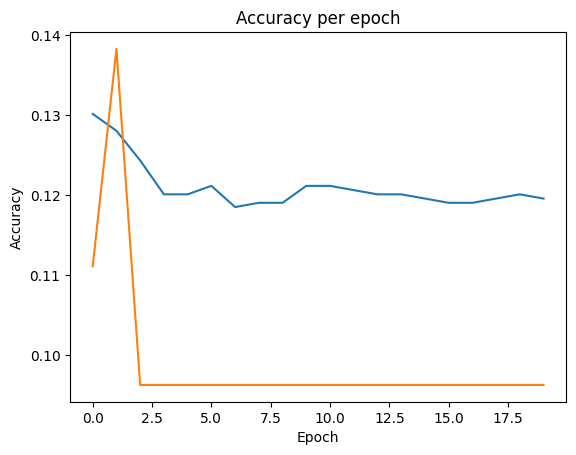

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()